# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
# Define number of patients, tissues, and clusters
n_patients = 500
n_tissues = 25
n_clusters = 10

# Generate tissue and cluster indices for each patient
basket_coords = np.arange(n_tissues)
cluster_coords = np.arange(n_clusters)
basket_idx = np.random.choice(basket_coords, size=n_patients)
cluster_idx = np.random.choice(cluster_coords, size=n_patients)

# Generate synthetic responsiveness data
theta_basket = np.random.normal(loc=0, scale=2, size=n_tissues)

# Generate unique prior mean and std for each column in theta_cluster
prior_means = np.random.normal(loc=0, scale=2, size=n_clusters)
prior_std_mean = 0 # mean of the half-normal distribution
prior_std_std = 1 # standard deviation of the half-normal distribution
prior_std_scale = np.sqrt(2) * prior_std_std / np.pi
prior_stds = halfnorm.rvs(loc=prior_std_mean, scale=prior_std_scale, size=n_clusters)

theta_cluster = np.zeros((n_tissues, n_clusters))
for i in range(n_clusters):
    theta_cluster[:,i] = np.random.normal(loc=prior_means[i], scale=prior_stds[i], size=n_tissues)

true_basket_p = logistic(theta_basket)
true_cluster_p = logistic(theta_cluster)
true_basket_reshaped = true_basket_p.reshape((n_tissues, 1))
true_mat = true_basket_reshaped * true_cluster_p

true_patient_p = true_mat[basket_idx, cluster_idx]
is_responsive = np.random.binomial(n=1, p=true_patient_p)

# Create synthetic data dataframe
data_df = pd.DataFrame({
    'basket_number': basket_idx,
    'cluster_number': cluster_idx,
    'responsive': is_responsive
})

# Print the first few rows of the data dataframe
data_df

,basket_number,cluster_number,responsive
0,6,6,0
1,19,3,0
2,14,0,0
3,10,4,1
4,7,6,0
...,...,...,...
495,4,8,0
496,11,4,0
497,15,2,0
498,15,4,0


In [7]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})

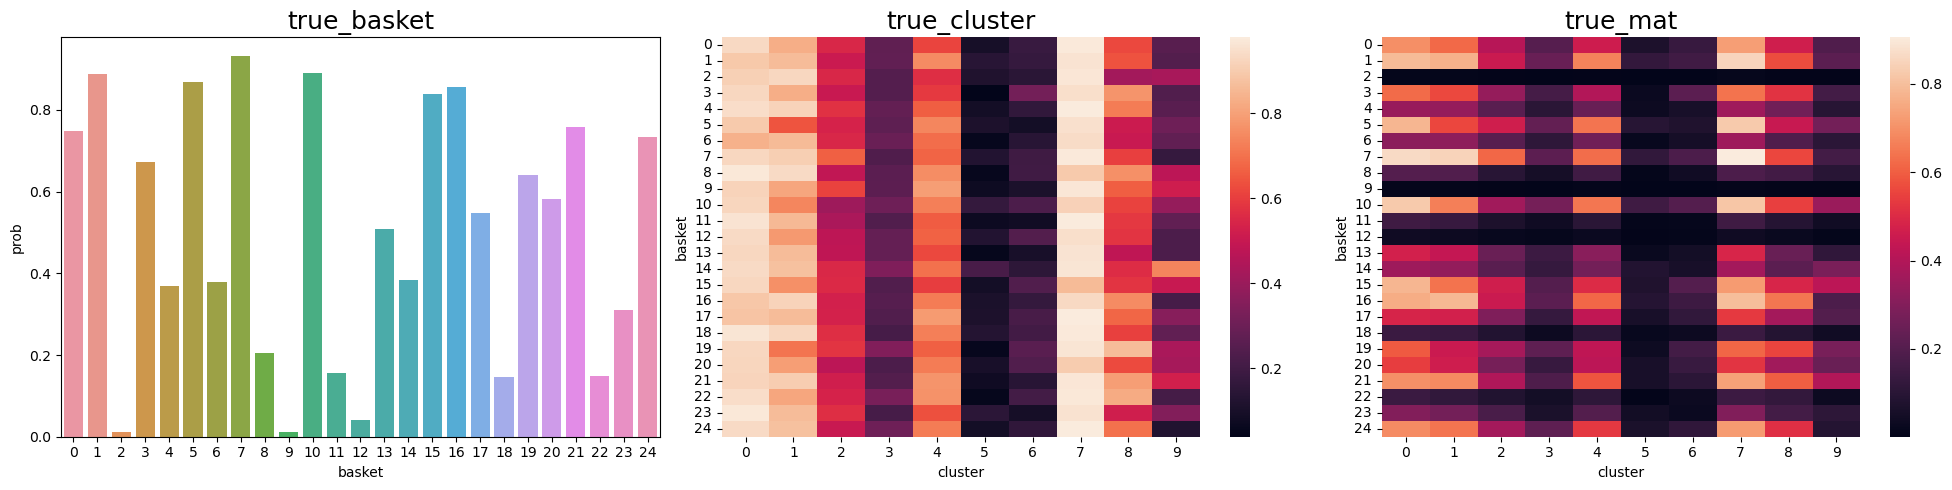

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax1)
sns.heatmap(true_cluster_p, ax=ax2)
sns.heatmap(true_mat, ax=ax3)

ax1.set_title('true_basket', fontsize=18)
ax2.set_title('true_cluster', fontsize=18)
ax2.set_xlabel('cluster')
ax2.set_ylabel('basket')
ax3.set_title('true_mat', fontsize=18)
ax3.set_xlabel('cluster')
ax3.set_ylabel('basket')
plt.tight_layout()

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [9]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [10]:
model_s = get_patient_model_simple(data_df)

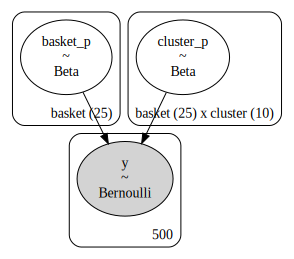

In [11]:
pm.model_to_graphviz(model_s)

In [12]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 61 seconds.


In [13]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[6],0.72,0.15,0.47,1.00,0.0,0.0,17856.0,11890.0,1.0
basket_p[19],0.91,0.08,0.76,1.00,0.0,0.0,24659.0,11319.0,1.0
basket_p[14],0.07,0.07,0.00,0.20,0.0,0.0,28352.0,11846.0,1.0
basket_p[10],0.69,0.18,0.40,1.00,0.0,0.0,21418.0,11544.0,1.0
basket_p[7],0.19,0.13,0.01,0.42,0.0,0.0,35022.0,13046.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[12, 5]",0.35,0.26,0.00,0.83,0.0,0.0,38047.0,11137.0,1.0
"cluster_p[12, 1]",0.42,0.28,0.00,0.89,0.0,0.0,36832.0,11870.0,1.0
"cluster_p[12, 2]",0.67,0.24,0.24,1.00,0.0,0.0,36719.0,12338.0,1.0
"cluster_p[12, 7]",0.43,0.24,0.04,0.87,0.0,0.0,32255.0,11868.0,1.0


In [14]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

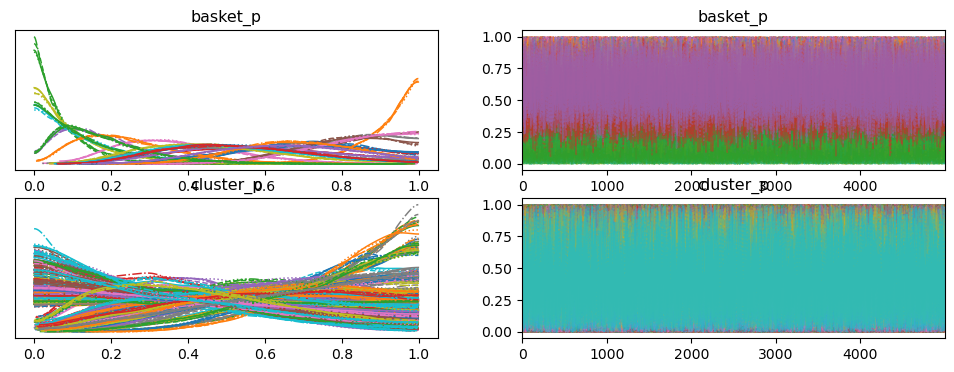

In [15]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

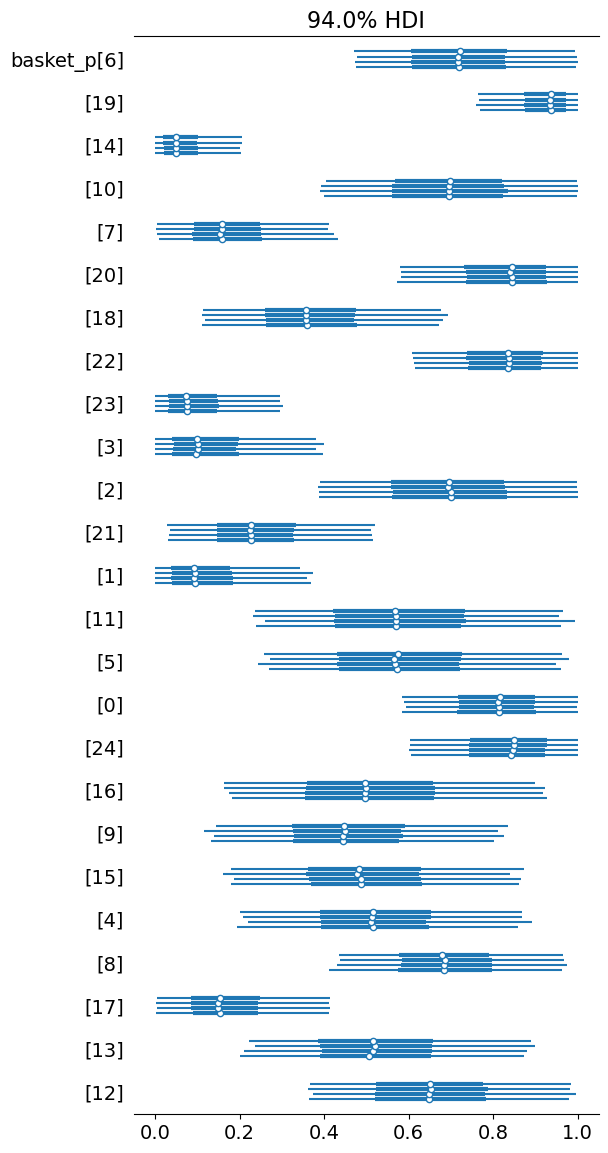

In [16]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [17]:
stacked_s = az.extract(trace_s)

In [18]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.12185651576147949)

In [19]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.2778966082175265)

In [20]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_s = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

### Hierarchical model 1

This hierarchical model suffers from a lot of divergences. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [21]:
model_h1 = get_patient_model_hierarchical(data_df)

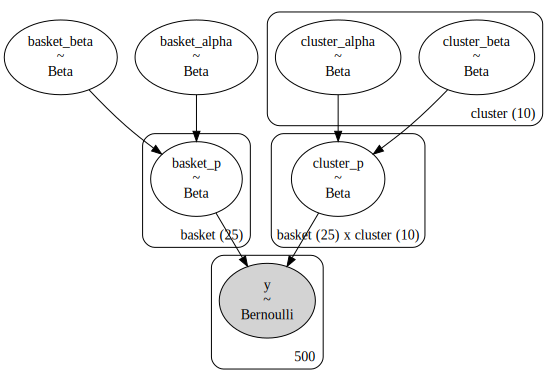

In [22]:
pm.model_to_graphviz(model_h1)

In [23]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 170 seconds.
There were 2299 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2329 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2335 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6707, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2399 divergences after tuning. Increase `target_accept` or reparameterize.


In [24]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_alpha,0.72,0.16,0.46,1.00,0.00,0.0,4853.0,6441.0,1.00
basket_beta,0.78,0.16,0.50,1.00,0.00,0.0,3120.0,4602.0,1.00
cluster_alpha[6],0.75,0.18,0.41,1.00,0.00,0.0,3191.0,3135.0,1.00
cluster_alpha[3],0.71,0.20,0.34,1.00,0.00,0.0,3204.0,2455.0,1.00
cluster_alpha[0],0.66,0.22,0.28,1.00,0.00,0.0,1796.0,1438.0,1.00
...,...,...,...,...,...,...,...,...,...
"cluster_p[12, 5]",0.09,0.20,0.00,0.51,0.00,0.0,299.0,162.0,1.01
"cluster_p[12, 1]",0.28,0.31,0.00,0.90,0.00,0.0,2578.0,2075.0,1.00
"cluster_p[12, 2]",0.92,0.17,0.56,1.00,0.00,0.0,3431.0,2882.0,1.00
"cluster_p[12, 7]",0.53,0.30,0.10,1.00,0.01,0.0,1561.0,705.0,1.00


In [25]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

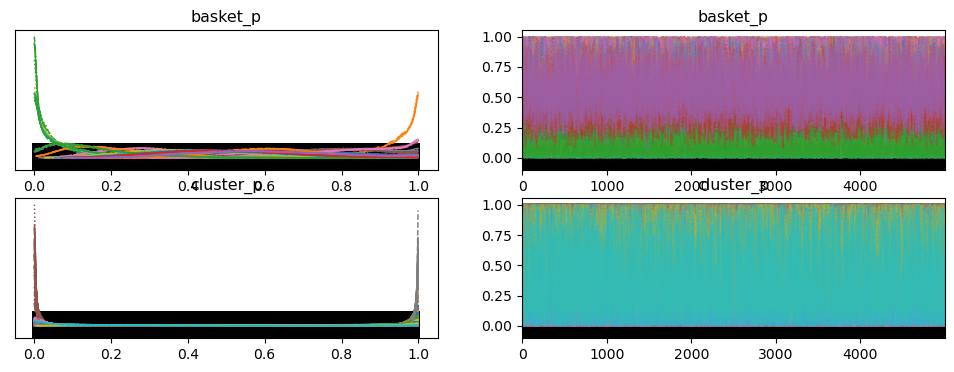

In [26]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

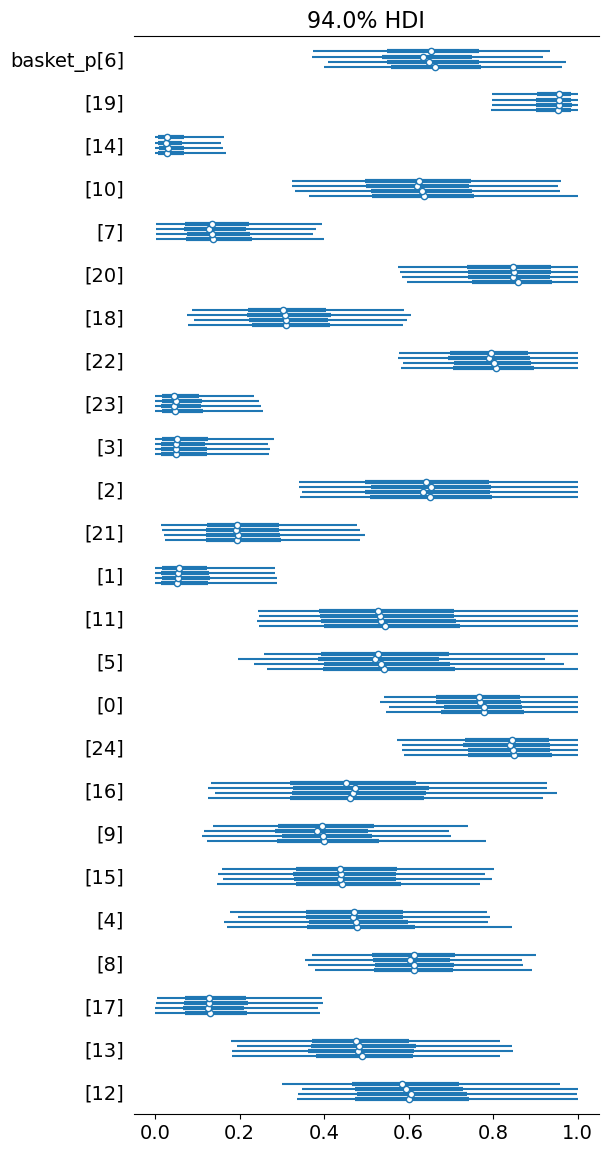

In [27]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [28]:
stacked_h1 = az.extract(trace_h1)

In [29]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.12584974725056067)

In [30]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.17614398058915126)

In [31]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [32]:
model_h2 = get_patient_model_hierarchical_log_odds(data_df)

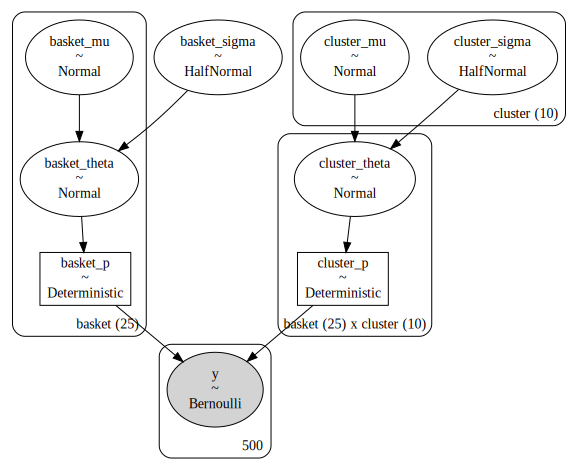

In [33]:
pm.model_to_graphviz(model_h2)

In [34]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [35]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(data_df)

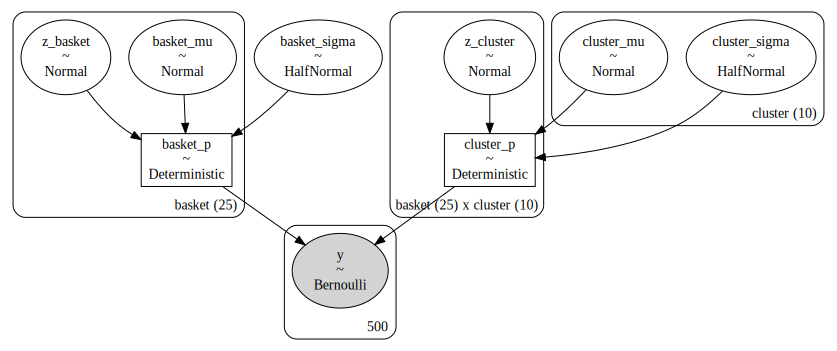

In [36]:
pm.model_to_graphviz(model_h2_nc)

In [37]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 103 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7143, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6619, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [38]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[6],0.20,0.95,-1.59,1.98,0.01,0.01,12372.0,12382.0,1.0
z_basket[19],0.43,0.99,-1.42,2.30,0.01,0.01,15426.0,11890.0,1.0
z_basket[14],-0.47,1.01,-2.31,1.46,0.01,0.01,11897.0,10542.0,1.0
z_basket[10],0.11,0.95,-1.71,1.84,0.01,0.01,15713.0,13008.0,1.0
z_basket[7],-0.27,0.94,-2.05,1.50,0.01,0.01,12513.0,8515.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[12, 5]",0.12,0.11,0.00,0.30,0.00,0.00,12390.0,7589.0,1.0
"cluster_p[12, 1]",0.26,0.16,0.00,0.55,0.00,0.00,16759.0,13686.0,1.0
"cluster_p[12, 2]",0.92,0.09,0.77,1.00,0.00,0.00,12902.0,9665.0,1.0
"cluster_p[12, 7]",0.59,0.18,0.24,0.94,0.00,0.00,12481.0,10839.0,1.0


In [39]:
# az.plot_ess(
#     trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

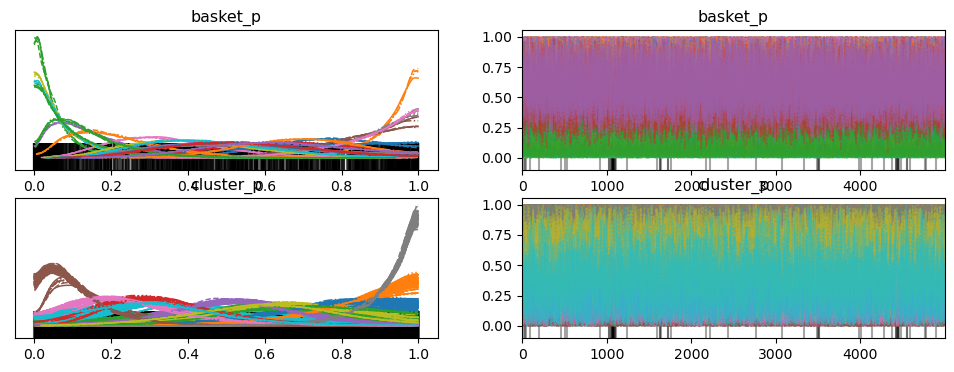

In [40]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

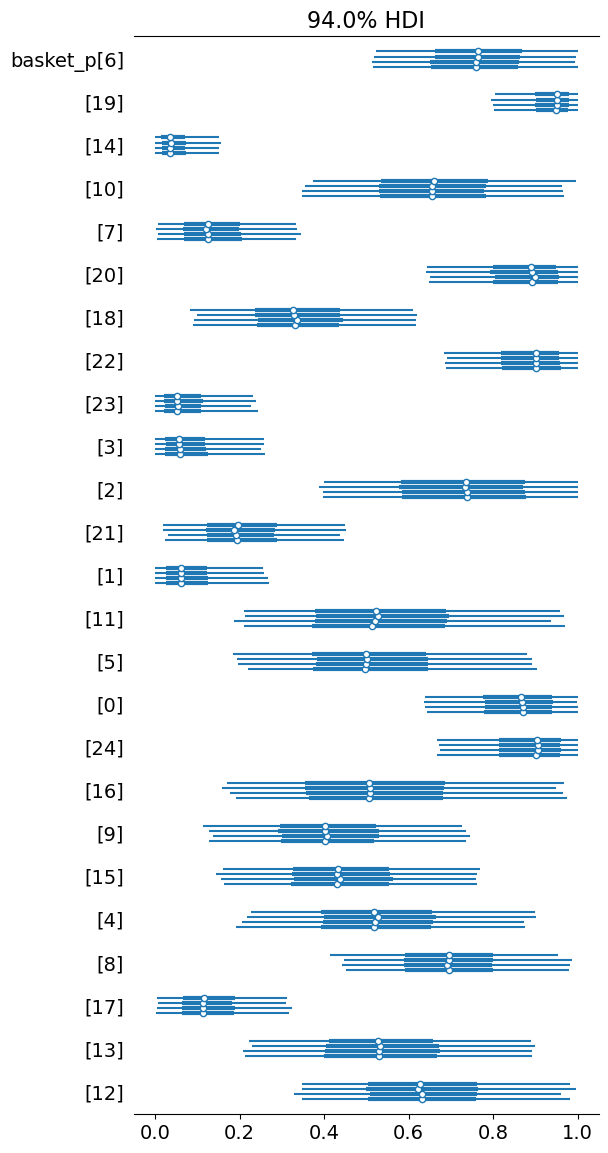

In [41]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [42]:
stacked_h2 = az.extract(trace_h2)

In [43]:
inferred_basket_p = np.mean(stacked_h2.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.11241975057817824)

In [44]:
inferred_cluster_p = np.mean(stacked_h2.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.1142592852111965)

In [45]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h2 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 10), (25, 10), (25, 10))

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [46]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,s,0.121857
1,h1,0.125850
2,h2,0.112420


Calculate root mean squared error for cluster_p

In [47]:
actual = true_cluster_p

predicted_cluster_s = np.mean(stacked_s.cluster_p.values, axis=2)
rmse_s = math.sqrt(mean_squared_error(actual, predicted_cluster_s))

predicted_cluster_h1 = np.mean(stacked_h1.cluster_p.values, axis=2)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_cluster_h1))

predicted_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,s,0.277897
1,h1,0.176144
2,h2,0.114259


Make plot

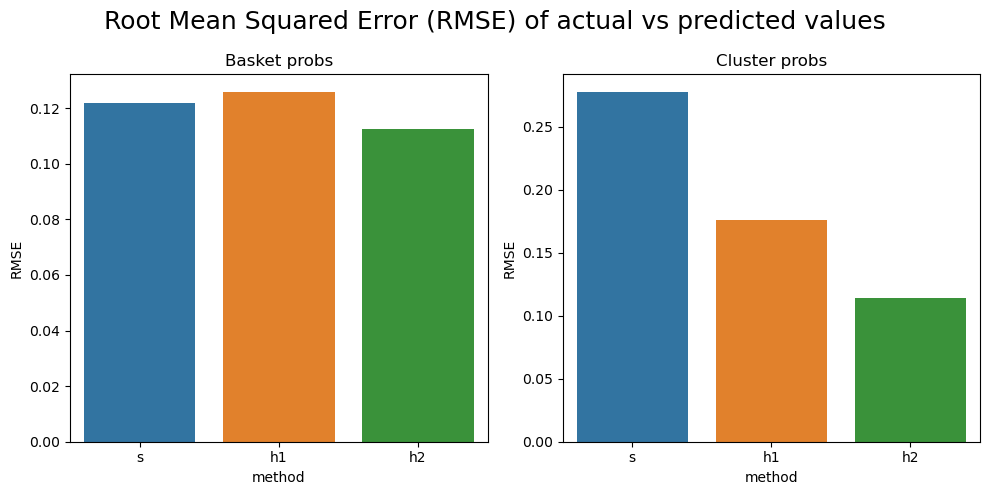

In [48]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(0.5, 1.0, 'Inferred (hierarchical log-odds)')

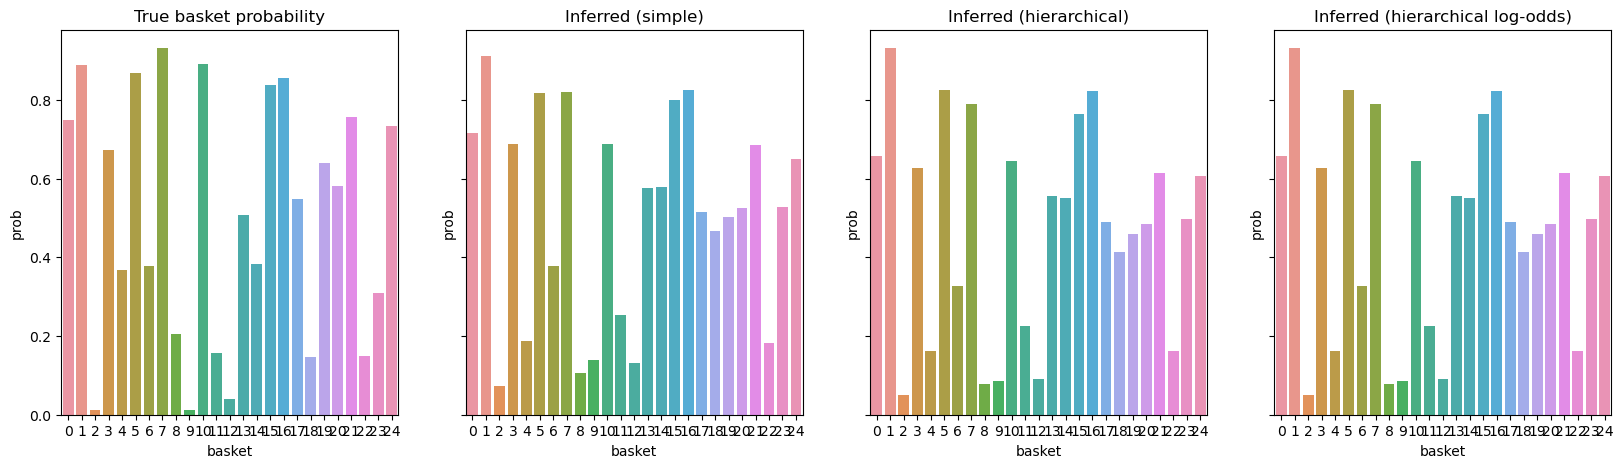

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('True basket probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')

Text(1452.626811594203, 0.5, 'Baskets')

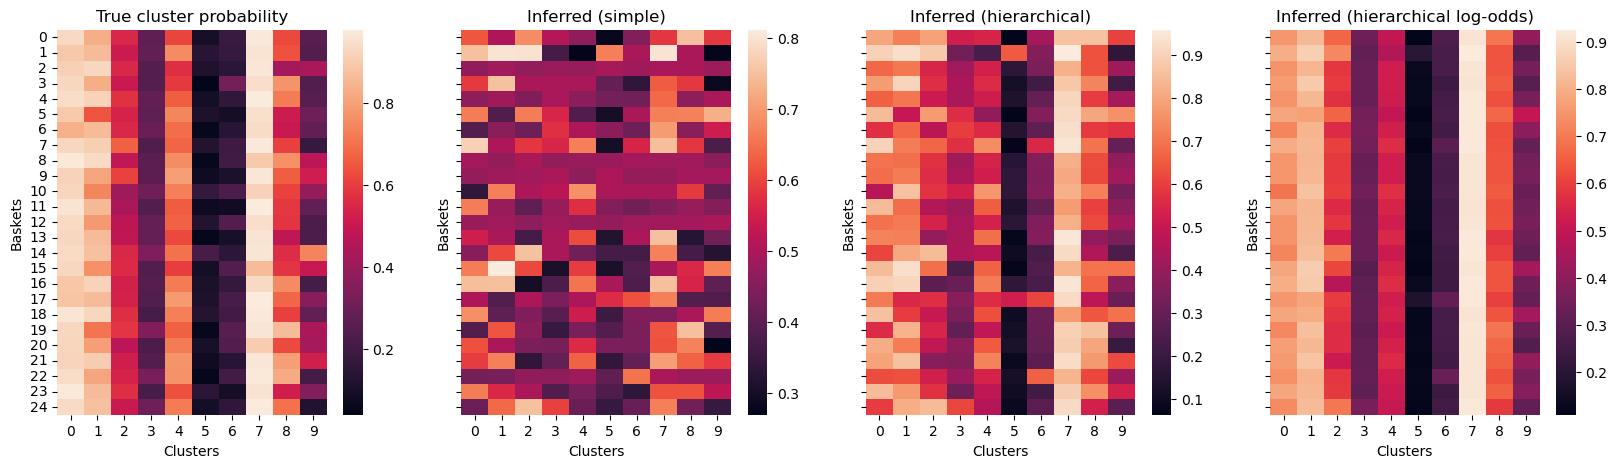

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_cluster_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Text(1452.626811594203, 0.5, 'Baskets')

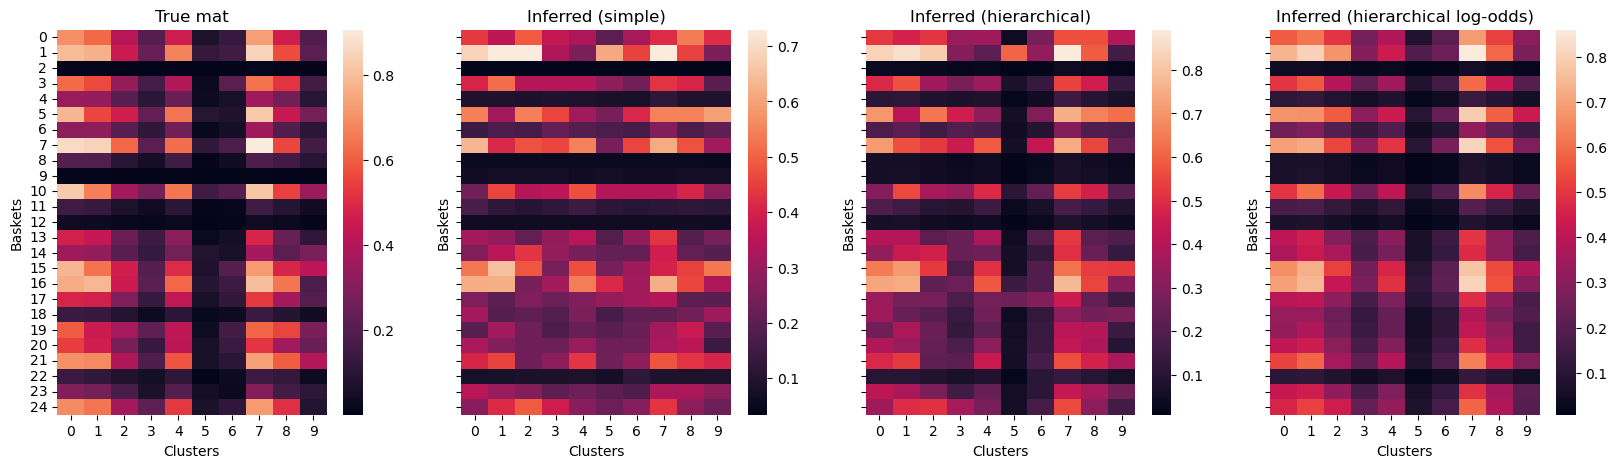

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True mat')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [52]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [53]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [54]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_mat, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_mat_h2, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

,method,top,bottom,total,N
0,s,1,1,2,5
1,h1,1,3,4,5
2,h2,3,3,6,5
3,s,6,5,11,10
4,h1,7,6,13,10
5,h2,7,6,13,10
6,s,9,7,16,15
7,h1,11,10,21,15
8,h2,11,9,20,15
9,s,10,7,17,20


Text(0.5, 1.0, 'Correct most-responsive partitions')

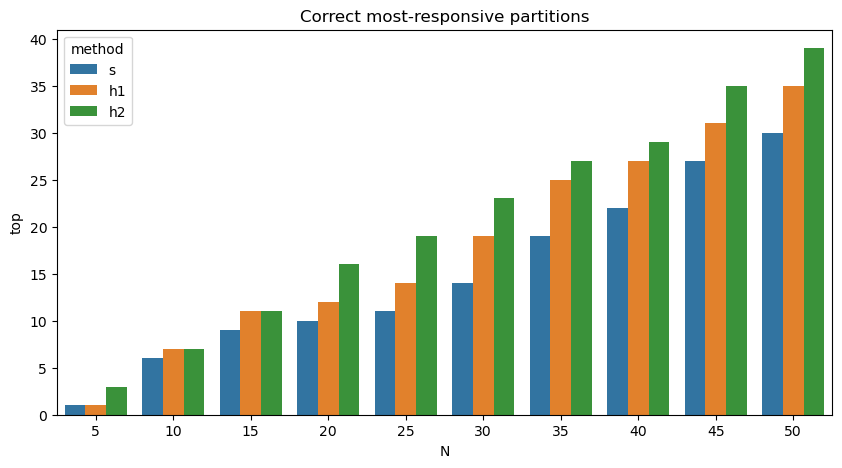

In [55]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

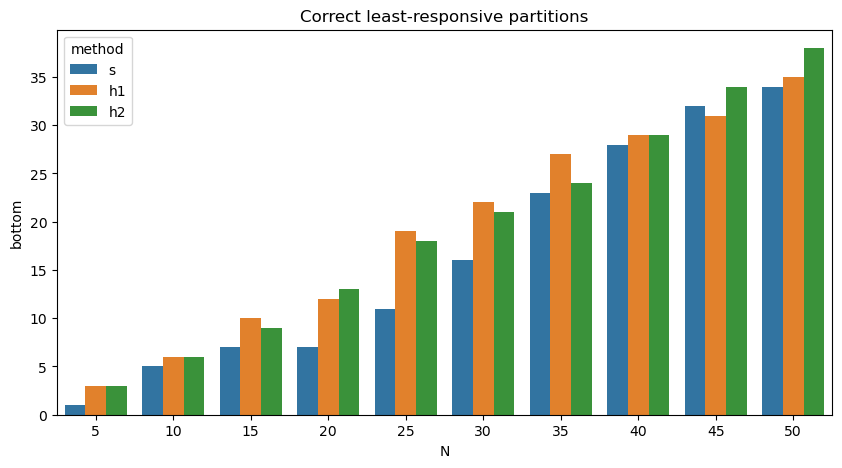

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [57]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [58]:
loo_s = az.loo(trace_s)
loo_s

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -258.99    11.31
p_loo       58.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      474   94.8%
 (0.5, 0.7]   (ok)         23    4.6%
   (0.7, 1]   (bad)         3    0.6%
   (1, Inf)   (very bad)    0    0.0%

In [59]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -247.87    12.19
p_loo       65.75        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      433   86.6%
 (0.5, 0.7]   (ok)         54   10.8%
   (0.7, 1]   (bad)        13    2.6%
   (1, Inf)   (very bad)    0    0.0%

In [60]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -239.90    11.93
p_loo       38.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      484   96.8%
 (0.5, 0.7]   (ok)         16    3.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [61]:
ic = 'loo'
df_comp_loo = az.compare({
    's': loo_s, 
    'h1': loo_h1,
    'h2': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
h2,0,-239.896210,38.211496,0.000000,1.000000e+00,11.931734,0.000000,False,log
h1,1,-247.869337,65.751166,7.973127,7.578937e-13,12.191385,3.243847,True,log
s,2,-258.994398,58.318826,19.098187,0.000000e+00,11.308117,5.431428,True,log


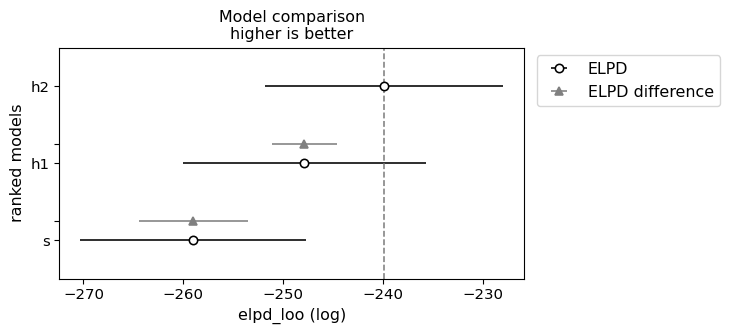

In [62]:
az.plot_compare(df_comp_loo);